In [1]:
# Module that executes the PostgreSQL geo-matching statements
sg_yelp_matching = __import__('sname-yelp-matching')
# PostgreSQL library
import psycopg2
# Reimport library
import importlib
# Database interaction library
import sqlalchemy as db
# Logging library 
import logging 
logging.basicConfig(level=logging.INFO)
# Print-functions-code library
import inspect
# Plottng library
from matplotlib import pyplot as plt
# Numpy 
import numpy as np

In [2]:
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname1}')
connection = engine.connect()

In [ ]:
lines = inspect.getsource(sg_yelp_matching)
print(lines)

In [ ]:
from importlib import reload
sg_yelp_matching = reload(sg_yelp_matching)

In [3]:
matched_by_distance = sg_yelp_matching.match_candidates_by_distance(connection)

INFO:root:Creating restaurants table.
INFO:root:Restaurants table created.
INFO:root:Creating Yelp copy.
INFO:root:Yelp copy created.
INFO:root:Doing the spatial join.
INFO:root:Spatial join completed.


In [4]:
# Unique Sname restaurants in the matched_by_distance
unique_restaurants = matched_by_distance.sname_place_id.nunique()
unique_restaurants

594374

In [5]:
# Number of potential matches
matched_by_distance.shape

(674090, 13)

In [6]:
# Preview matches
matched_by_distance.head()

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance
0,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,Z19kDppC2EAzT3s31mYtIA,New Ocean Chinese Restaurant,+18059251500,93458,331 Town Ctr W,1.616780
1,sg:00001b8625b64052888b8c2f2e3736bb,Golden Corral,32819,orlando,fl,8032 international drive,+14073526606,None,None,None,None,None,NaN
2,sg:0000342b96c3453fbcd3c80308517f75,Pizza Hut,32348,perry,fl,2199 south byron butler parkway,+18505847480,pYrHAeko8pAwWyxn0Hgltw,Pizza Hut,+18505847480,32347,2199 S Byron Butler Pkwy,3.335255
3,sg:00003430f2e24d3d9579db600cdcd4f0,Nacho Bizness,93940,monterey,ca,615 lighthouse avenue,+18315555555,WWtRHUn3SkB5UPPdZubsBg,Nacho Bizness,+18315555555,93940,615 Lighthouse Ave,4.396159
4,sg:00003e1625674e2f812a9d8d6e992058,Schmizza,97232,portland,or,628 north east broadway street,+15035179981,None,None,None,None,None,NaN


In [7]:
# Levenshtein-distance similarity metric defined
from Levenshtein import ratio
def levenstein(row):
    if ((row['r_location_name'] is None) or (row['y_name'] is None)):
        return 0.0
    else:
        return ratio(row['r_location_name'].lower(), row['y_name'].lower())

In [8]:
# Name similarity (SG - Yelp) computation
matched_by_distance['name_similarity'] = matched_by_distance.apply(lambda row: levenstein(row), 
                                                    axis = 1)

In [9]:
# Select best match based on name similarity (among very close restaurants)
matched_by_distance_name = matched_by_distance.sort_values('name_similarity', 
                                                           ascending = False).drop_duplicates(['sname_place_id'])
# Shape of the resulting match table
assert matched_by_distance_name.shape[0] == unique_restaurants
matched_by_distance_name.shape[0]

594374

In [10]:
# Functions to compute share of 'good' matches for a given threshold:
def share_good_matches_name(threshold):
    good = sum(matched_by_distance_name['name_similarity'] >= threshold)
    return float(good) / matched_by_distance_name.shape[0]

# This function matches considers a match to be good if
# names are similar and phone number coincides
def share_good_matches_phone(threshold_main, threshold_phone):
    good = sum((matched_by_distance_name['name_similarity'] >= threshold_main) |
               ((matched_by_distance_name['r_phone_number'] == matched_by_distance_name['y_phone']) &
                (matched_by_distance_name['name_similarity'] >= threshold_phone)
               )
              )
    return float(good) / matched_by_distance_name.shape[0]

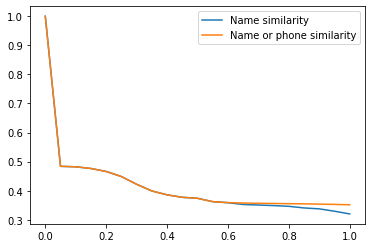

In [12]:
# Plot share of good matches for different thresholds
t = np.linspace(0,1,21)
shares_name = list(map(share_good_matches_name, t))
shares_phone = list(map(lambda x: share_good_matches_phone(x, 0.6), t))
plt.plot(t, shares_name, label = "Name similarity")
plt.plot(t, shares_phone, label = "Name or phone similarity")
plt.legend(loc = 'upper right')
plt.show()

In [13]:
print(share_good_matches_phone(0.85, 0.6))
print(share_good_matches_phone(0.85, 0.7))
print(share_good_matches_phone(0.85, 0.85))
print(share_good_matches_name(0.85))

0.35475979770312965
0.34886451964587956
0.3407147688155942
0.3407147688155942


In [14]:
# Set the thresholds
threshold_main = 0.85
threshold_phone = 0.7
match_criterion = ((matched_by_distance_name['name_similarity'] >= threshold_main) |
                   ((matched_by_distance_name['r_phone_number'] == matched_by_distance_name['y_phone']) &
                    (matched_by_distance_name['name_similarity'] >= threshold_phone)
                   )
                  )
print(share_good_matches_phone(threshold_main, threshold_phone))
# Preview of matches
matched_by_distance_name.loc[match_criterion]

0.34886451964587956


,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance,name_similarity
0,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,Z19kDppC2EAzT3s31mYtIA,New Ocean Chinese Restaurant,+18059251500,93458,331 Town Ctr W,1.616780,1.0
326789,sg:79108b15db7441d49d0305d89ee8b297,Los Tres Amigos,48917,lansing,mi,5010 west saginaw highway,+15173270545,JeHxq7ey2NvhFvx5jFvKMg,Los Tres Amigos,+15173270545,48917,5010 W Saginaw Hwy,7.910377,1.0
326719,sg:790a9871773c44f1b77143d3da426c18,Kulture Kurry,66210,overland park,ks,9940 college boulevard,+19133399511,35MJhS4DM6-woFbvzvzaEg,Kulture Kurry,+19133399511,66210,9940 College Blvd,2.543813,1.0
326718,sg:790a8be19ee14da09a307740b1b476e8,Sunset Pizza & Grille,15106,carnegie,pa,38 east main,+14122763103,Blw30ULdFKSOgCmf9lfGLg,Sunset Pizza & Grille,+14122763103,15106,38 E Main,17.625710,1.0
326712,sg:7909f15658d34d7bb9940b7f5c2b1aae,BurgerFi,34110,naples,fl,1514 immokalee road unit 101,None,1Gs_LrTOiA3kzkUSJmcHDA,BurgerFi,+12396318227,34110,1514 Immokalee Rd,21.815065,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600712,sg:e32a8d0d46a24ca6ac6ee0e240cd6c41,Bob's Big Boy,48135,garden city,mi,28340 ford road,+17344252360,rGCCxVTWA28WTLOpQGg8hA,Big Boy,+17344252360,48135,28340 Ford Rd,19.867434,0.7
639358,sg:f250d636102c43b6b6131034048f08c4,Sukeban,78210,san antonio,tx,1420 south alamo street,+12105623231,Lu3y5ztXoE2lT3TvFYS0tQ,Sukeban Sushi,+12105623231,78210,1420 S Alamo St,10.857860,0.7
124735,sg:2d60249485984bd9aa87a99af85466e5,Little Caesars,44805,ashland,oh,1127 claremont avenue,+14192898012,-2CFoQcoqnSBNBCQztaCZA,Little Caesars Enterprises,+14192898012,44805,1127 Claremont Ave,9.802918,0.7
125695,sg:2dbc00dd10224c6a9180032db8585458,Fell St Deli,18250,summit hill,pa,19 north market street,+15706459148,5hUU6Irw7CTj2Gho_yYTkA,PLS Deli,+15706459148,18250,19 N Market St,5.089645,0.7


In [15]:
# Preview of non-matches:
matches_test = ((matched_by_distance_name['name_similarity'] >= 0.2) &
                (matched_by_distance_name['name_similarity'] <= 0.25) &
                (matched_by_distance_name['r_phone_number'] == matched_by_distance_name['y_phone'])
               )
matched_by_distance_name.loc[matches_test]

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance,name_similarity
48910,sg:11b9a3b312e34ff698e76413c0b75957,Tang's Dynasty,11779,ronkonkoma,ny,846 portion road,+16315888885,E9f_moj4rkxfEe9UgGYMRA,Kira sushi,+16315888885,11779,846 Portion Rd,24.137632,0.25
69730,sg:19497e67a2154304a71a983f93ecf8ae,Western Sizzlin,72015,benton,ar,1916 congo road,+15017789656,8kpUW4N5-19uyD6cWUDTZg,Wood Grill Buffet,+15017789656,72015,1916 Congo Rd,2.965155,0.25
329149,sg:79f4dc1af85d45cc9f08d9e1e048a6d1,Spicy King,92084,vista,ca,1233 east vista way,+17606391888,bec1DiblXIgKLjo6MxnPwg,Kung Fu Noodle,+17606391888,92084,1233 E Vista Way,26.727000,0.25
266707,sg:625d5fda4cd24be7a57bf906a0c4ca89,Krispy Krunchy Chicken,45324,beavercreek,oh,3800 colonel glenn highway,+19374277482,beMiOjdVXzhV1lP87O-AwQ,Taste of Jerusalem,+19374277482,45324,3800 Colonel Glenn Hwy,10.481496,0.25
89742,sg:2095c69cf3d3446a8271fc2af7e54c49,TRP Taste,33301,fort lauderdale,fl,1 west las olas,+19545231956,TCAIABRcO4z8RS-FSjTrXw,Rooftop,+19545231956,33301,1 West Las Olas,1.902920,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23272,sg:0869dffa48cd44d2a247d06ec72448b3,China Gate,30096,duluth,ga,2340 satellite boulevard,+16784731688,cEB2YRuhR_VDe01BCju9rQ,Firey Bowl,+16784731688,30096,2340 Satellite Blvd,14.920370,0.20
595657,sg:e12a7059ae21451da8e4338facd5ac7e,Pizza Factory,97266,portland,or,10114 south east division street,+15037616500,1jEaGRvGhdQ2sSdo5Ngg2A,Andale Andale PDX,+15037616500,97266,10114 SE Division St,9.907677,0.20
350340,sg:821aaf838e4c4c448f489bf5445371ee,Taqueria El Mezcal,11232,new york,ny,3910 fourth avenue,+17187682846,B9oTzVAux2o4pzWjvBw3rQ,Nacho Crespo,+17187682846,11232,3910 4th Ave,14.470078,0.20
309602,sg:728d452f06d144aebcfe72a4a8bca9dd,Ixca,46219,indianapolis,in,5537 east washington street,+13179864154,Tu0aKNaBuT2bAcrfnZFEvg,La Antigua Family Mexican Restaurant,+13179864154,46219,5537 E Washington St,1.766370,0.20


In [16]:
matched_by_distance_name['phone_request_status'] = 'needed'
matched_by_distance_name['address_request_status'] = 'needed'
# Mark rows where phone number is not available
missing_phones = matched_by_distance_name.r_phone_number.isnull()
matched_by_distance_name.loc[missing_phones,
                             'phone_request_status'] = 'unavail'
# Mark rows that satisfy the criterion as phone_request_needed = 'not_needed'
matched_by_distance_name.loc[match_criterion, 
                             ['phone_request_status', 
                              'address_request_status']
                            ] = 'not_needed'
matched_by_distance_name['phone_error_message'] = None
matched_by_distance_name['address_error_message'] = None

In [17]:
matched_by_distance_name

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance,name_similarity,phone_request_status,address_request_status,phone_error_message,address_error_message
0,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,Z19kDppC2EAzT3s31mYtIA,New Ocean Chinese Restaurant,+18059251500,93458,331 Town Ctr W,1.616780,1.0,not_needed,not_needed,None,None
326789,sg:79108b15db7441d49d0305d89ee8b297,Los Tres Amigos,48917,lansing,mi,5010 west saginaw highway,+15173270545,JeHxq7ey2NvhFvx5jFvKMg,Los Tres Amigos,+15173270545,48917,5010 W Saginaw Hwy,7.910377,1.0,not_needed,not_needed,None,None
326719,sg:790a9871773c44f1b77143d3da426c18,Kulture Kurry,66210,overland park,ks,9940 college boulevard,+19133399511,35MJhS4DM6-woFbvzvzaEg,Kulture Kurry,+19133399511,66210,9940 College Blvd,2.543813,1.0,not_needed,not_needed,None,None
326718,sg:790a8be19ee14da09a307740b1b476e8,Sunset Pizza & Grille,15106,carnegie,pa,38 east main,+14122763103,Blw30ULdFKSOgCmf9lfGLg,Sunset Pizza & Grille,+14122763103,15106,38 E Main,17.625710,1.0,not_needed,not_needed,None,None
326712,sg:7909f15658d34d7bb9940b7f5c2b1aae,BurgerFi,34110,naples,fl,1514 immokalee road unit 101,None,1Gs_LrTOiA3kzkUSJmcHDA,BurgerFi,+12396318227,34110,1514 Immokalee Rd,21.815065,1.0,not_needed,not_needed,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370582,sg:89e009dd6f854ac7bf03ee304697000d,La Real Michoacana,75217,dallas,tx,1401 south buckner boulevard,+12143919175,None,None,None,None,None,NaN,0.0,needed,needed,None,None
370576,sg:89df6eb191eb4dcb9095acaf3300563a,Mariella's Pizza,11010,franklin square,ny,191 franklin avenue,None,None,None,None,None,None,NaN,0.0,unavail,needed,None,None
370575,sg:89df2f133b7c459c8eee3b5054189f72,Oakwood Country Club,85248,sun lakes,az,24215 south oakwood boulevard,+14808951159,None,None,None,None,None,NaN,0.0,needed,needed,None,None
87189,sg:1fa9ae596a9241738f1438270205c896,Applebee's,66111,kansas city,ks,1700 village west parkway,+19137889421,None,None,None,None,None,NaN,0.0,needed,needed,None,None


In [18]:
# Export to PostgreSQL adding a primary key
requests_table = matched_by_distance_name[['sname_place_id',
                                           'r_phone_number',
                                           'r_location_name',
                                           'r_zip_code',
                                           'r_street_address',
                                           'r_city',
                                           'r_state',
                                           'y_id',
                                           'phone_request_status',
                                           'address_request_status',
                                           'phone_error_message',
                                           'address_error_message'
                                          ]]
requests_table.reset_index(drop = True, inplace = True)
requests_table.to_sql('restaurants_requests', 
                      con = engine, 
                      index = True, 
                      index_label = 'row_id',
                      dtype = {'phone_error_message': db.types.VARCHAR,
                               'address_error_message': db.types.VARCHAR
                              }
                     )
connection.execute('ALTER TABLE restaurants_requests ADD PRIMARY KEY (row_id);')

In [106]:
(matched_by_distance_name.loc[matched_by_distance_name['name_similarity'] <= threshold_main]).isnull().sum(axis = 0)

sname_place_id             0
r_location_name                0
r_zip_code                     0
r_city                         0
r_state                        0
r_street_address               0
r_phone_number             54350
y_id                      306387
y_name                    306387
y_phone                   309286
y_zip_code                306436
y_address1                306557
distance                  306387
name_similarity                0
request_done                   0
request_needed                 0
phone_request_needed           0
address_request_needed         0
phone_request_done             0
address_request_done           0
dtype: int64

In [19]:
engine.dispose()

In [ ]:
# Difflib similarity metric
from difflib import SequenceMatcher
import pandas as pd
def similar(row):
    if ((row['r_location_name'] is None) or (row['y_name'] is None)):
        return 0
    else:
        return SequenceMatcher(None, row['r_location_name'].lower(), row['y_name'].lower()).ratio()